In [215]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

import scipy
import pywt
import mne

import sys
from tqdm import tqdm
import math


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
from stats_utils import *

import glob
import os


#import seaborn as sns
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

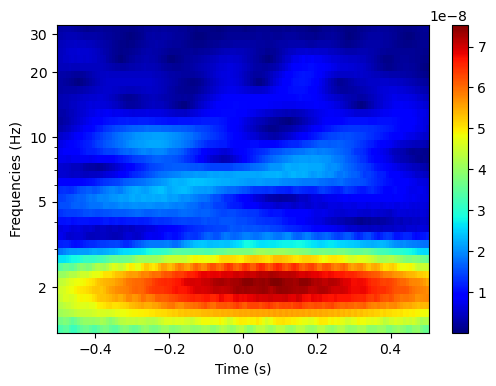

In [108]:
task = 'motor'
sub = '20'

wavelet_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/mTRF_onset/wavelet_{task}_Cz'
wavelet_data = loadmat(os.path.join(wavelet_path, f'mTRF_wavelet_{task}_post_{sub}.mat'))['wavelet_transform'][0][0]
wavelet_trans_info = loadmat(os.path.join(wavelet_path,f'wavelet_record.mat'))

times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()

plot_scaleogram(wavelet_data, freqs, times)

In [227]:
good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
subjects_to_process = good_motor_subjects
period = 'pre'
task = 'listen'

In [228]:
def plot_scaleogram_subplots(cwtmatr, freqs, times, vmax=None, ax=None):
    """
    Plots the scalogram of a wavelet transform given the complex matrix.

    Parameters:
    cwtmatr: ndarray
        The complex matrix of the wavelet transform.
    freqs: ndarray
        The frequencies corresponding to the wavelet transform.
    times: ndarray
        The time points corresponding to the wavelet transform.
    vmax: float, optional
        Scaling of the colorbar.
    ax: matplotlib.axes.Axes, optional
        An existing axis to plot on. If None, a new figure and axis are created.
    """
    if np.any(np.iscomplex(cwtmatr)):
        cwtmatr_abs = np.abs(cwtmatr)
    else:
        cwtmatr_abs = cwtmatr

    # Create a new figure and axis if ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size as needed

    pcm = ax.pcolormesh(times, freqs, cwtmatr_abs, vmax=vmax, cmap='jet')

    # Format axes
    ax.set_ylabel('Frequencies (Hz)')
    ax.set_xlabel('Time (s)')

    # Format y-axis for log scale
    ax.set_yscale('log')
    ax.set_yticks([2, 5, 10, 20, 30])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())

    # Add colorbar only if a new figure was created
    if ax is None:
        fig.colorbar(pcm, ax=ax)
    else:
        plt.colorbar(pcm, ax=ax)

    return ax

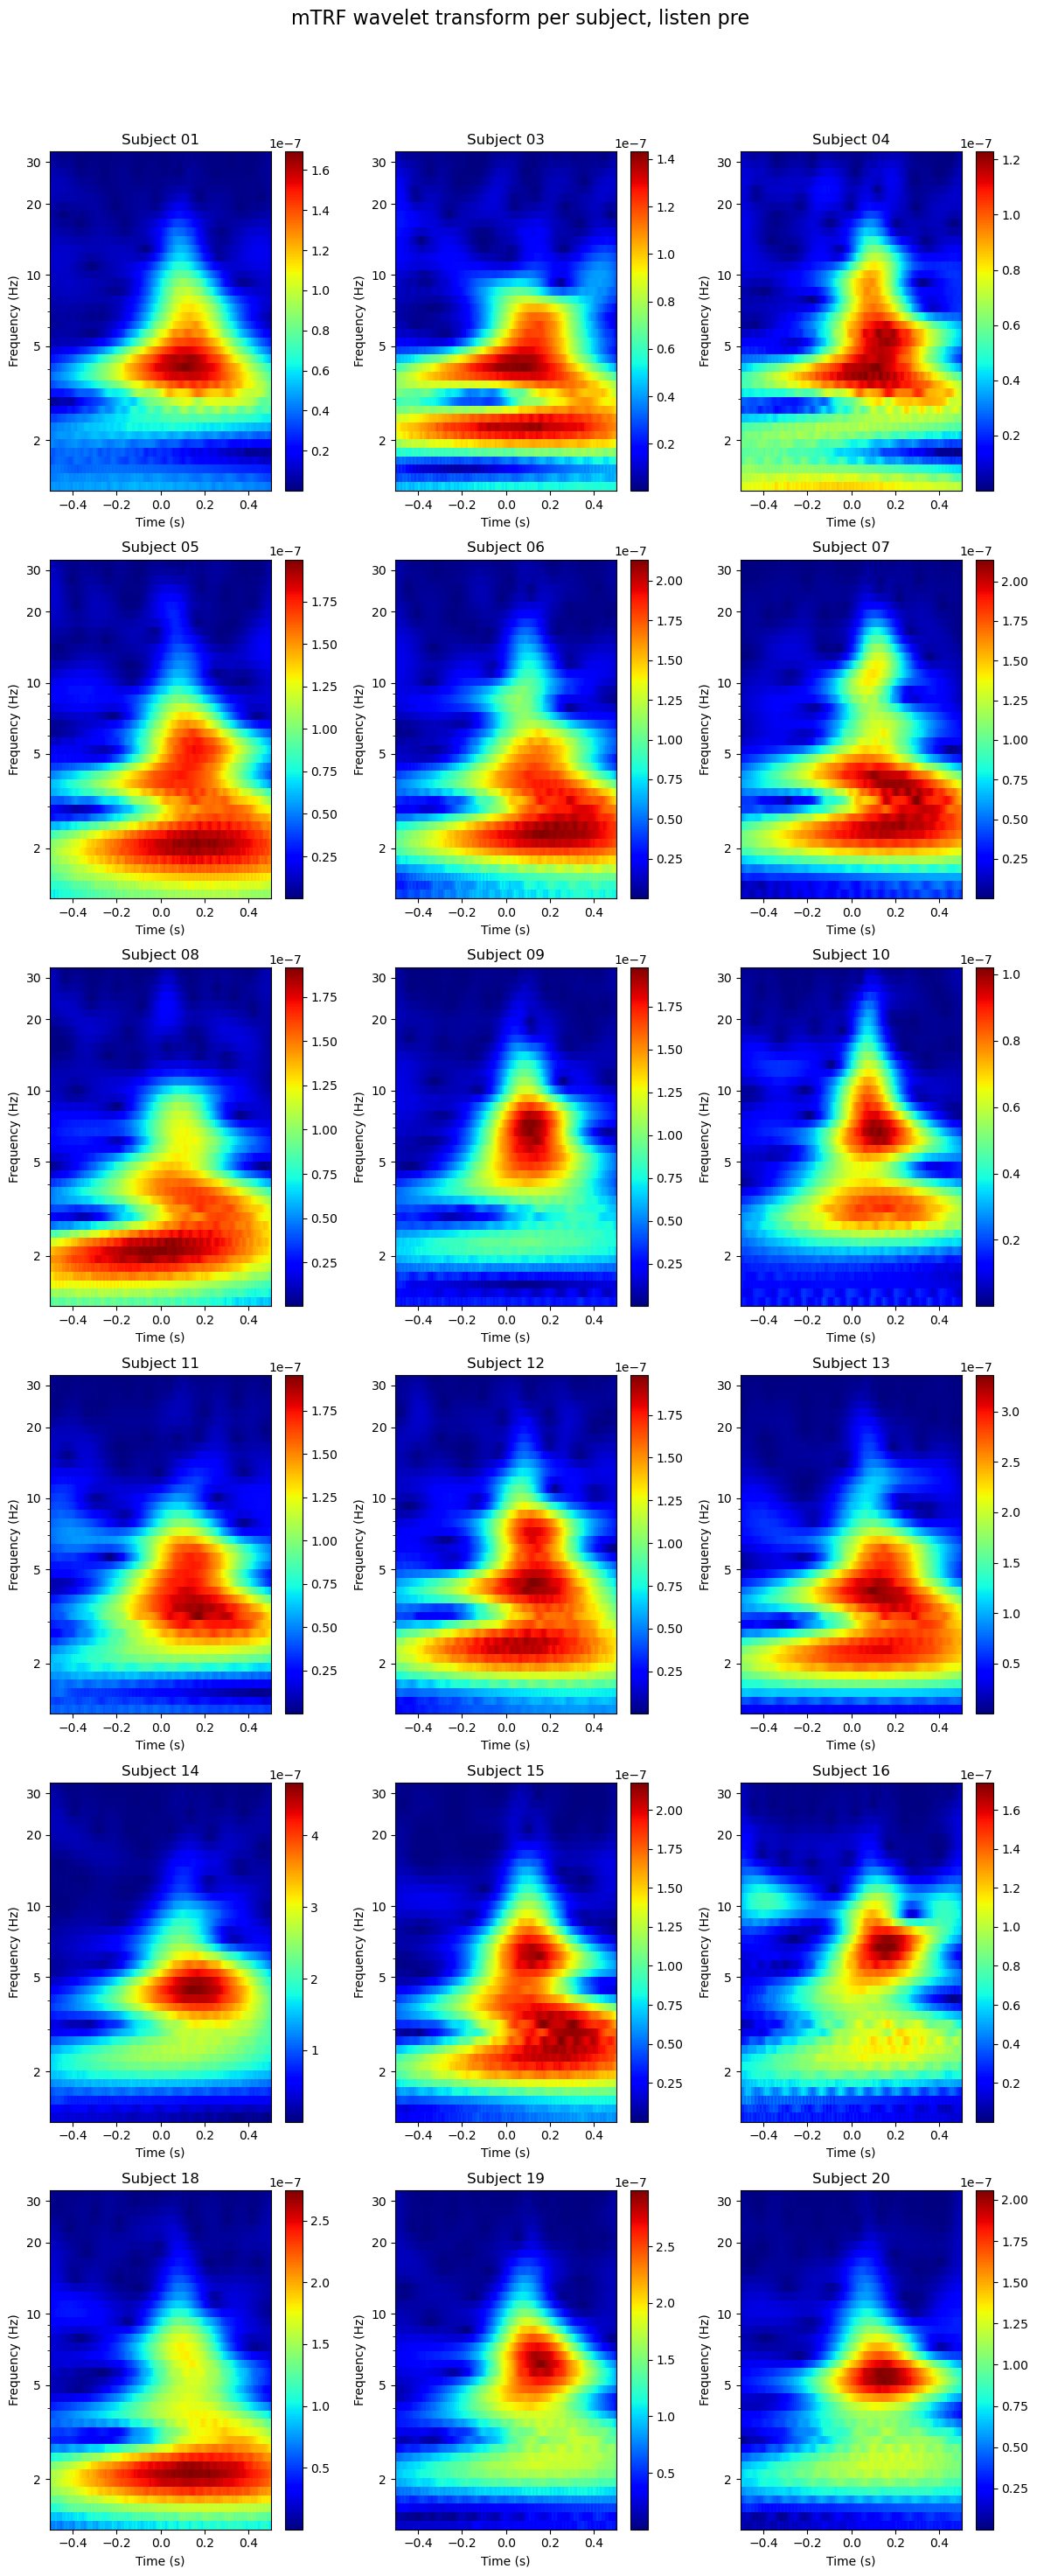

In [230]:

wavelet_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/mTRF_onset/wavelet_{task}_Cz'
#wavelet_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/mTRF_onset/wavelet_{task}_all'

# Define grid layout for subplots
num_columns = 3  # Adjust the number of columns as needed
num_rows = math.ceil(len(subjects_to_process) / num_columns)

# Create a figure
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 5 * num_rows))
axes = axes.flatten()  # Flatten to make indexing easier
fig.suptitle(f'mTRF wavelet transform per subject, {task} {period}', fontsize=16)

for i, sub in enumerate(subjects_to_process):
    # Load wavelet data
    #if all channels 
    wavelet_data_allch = loadmat(os.path.join(wavelet_path, f'mTRF_wavelet_{task}_{period}_{sub}.mat'))['wavelet_transform'][0]
    
    #if one channel only
    wavelet_data = loadmat(os.path.join(wavelet_path, f'mTRF_wavelet_{task}_{period}_{sub}.mat'))['wavelet_transform'][0][0]

    #if all channels, take mean
    wavelet_data = np.mean(wavelet_data_allch, axis = 0)
    wavelet_trans_info = loadmat(os.path.join(wavelet_path, 'wavelet_record.mat'))

    times = wavelet_trans_info['times'].squeeze() 
    freqs = wavelet_trans_info['freqs'].squeeze()

    # Plot on the respective subplot
    ax = axes[i]
    plot_scaleogram_subplots(wavelet_data, freqs, times, ax=ax)
    ax.set_title(f'Subject {sub}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    #ax.set_ylim(8,32)

# Turn off unused subplots
for j in range(len(subjects_to_process), len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

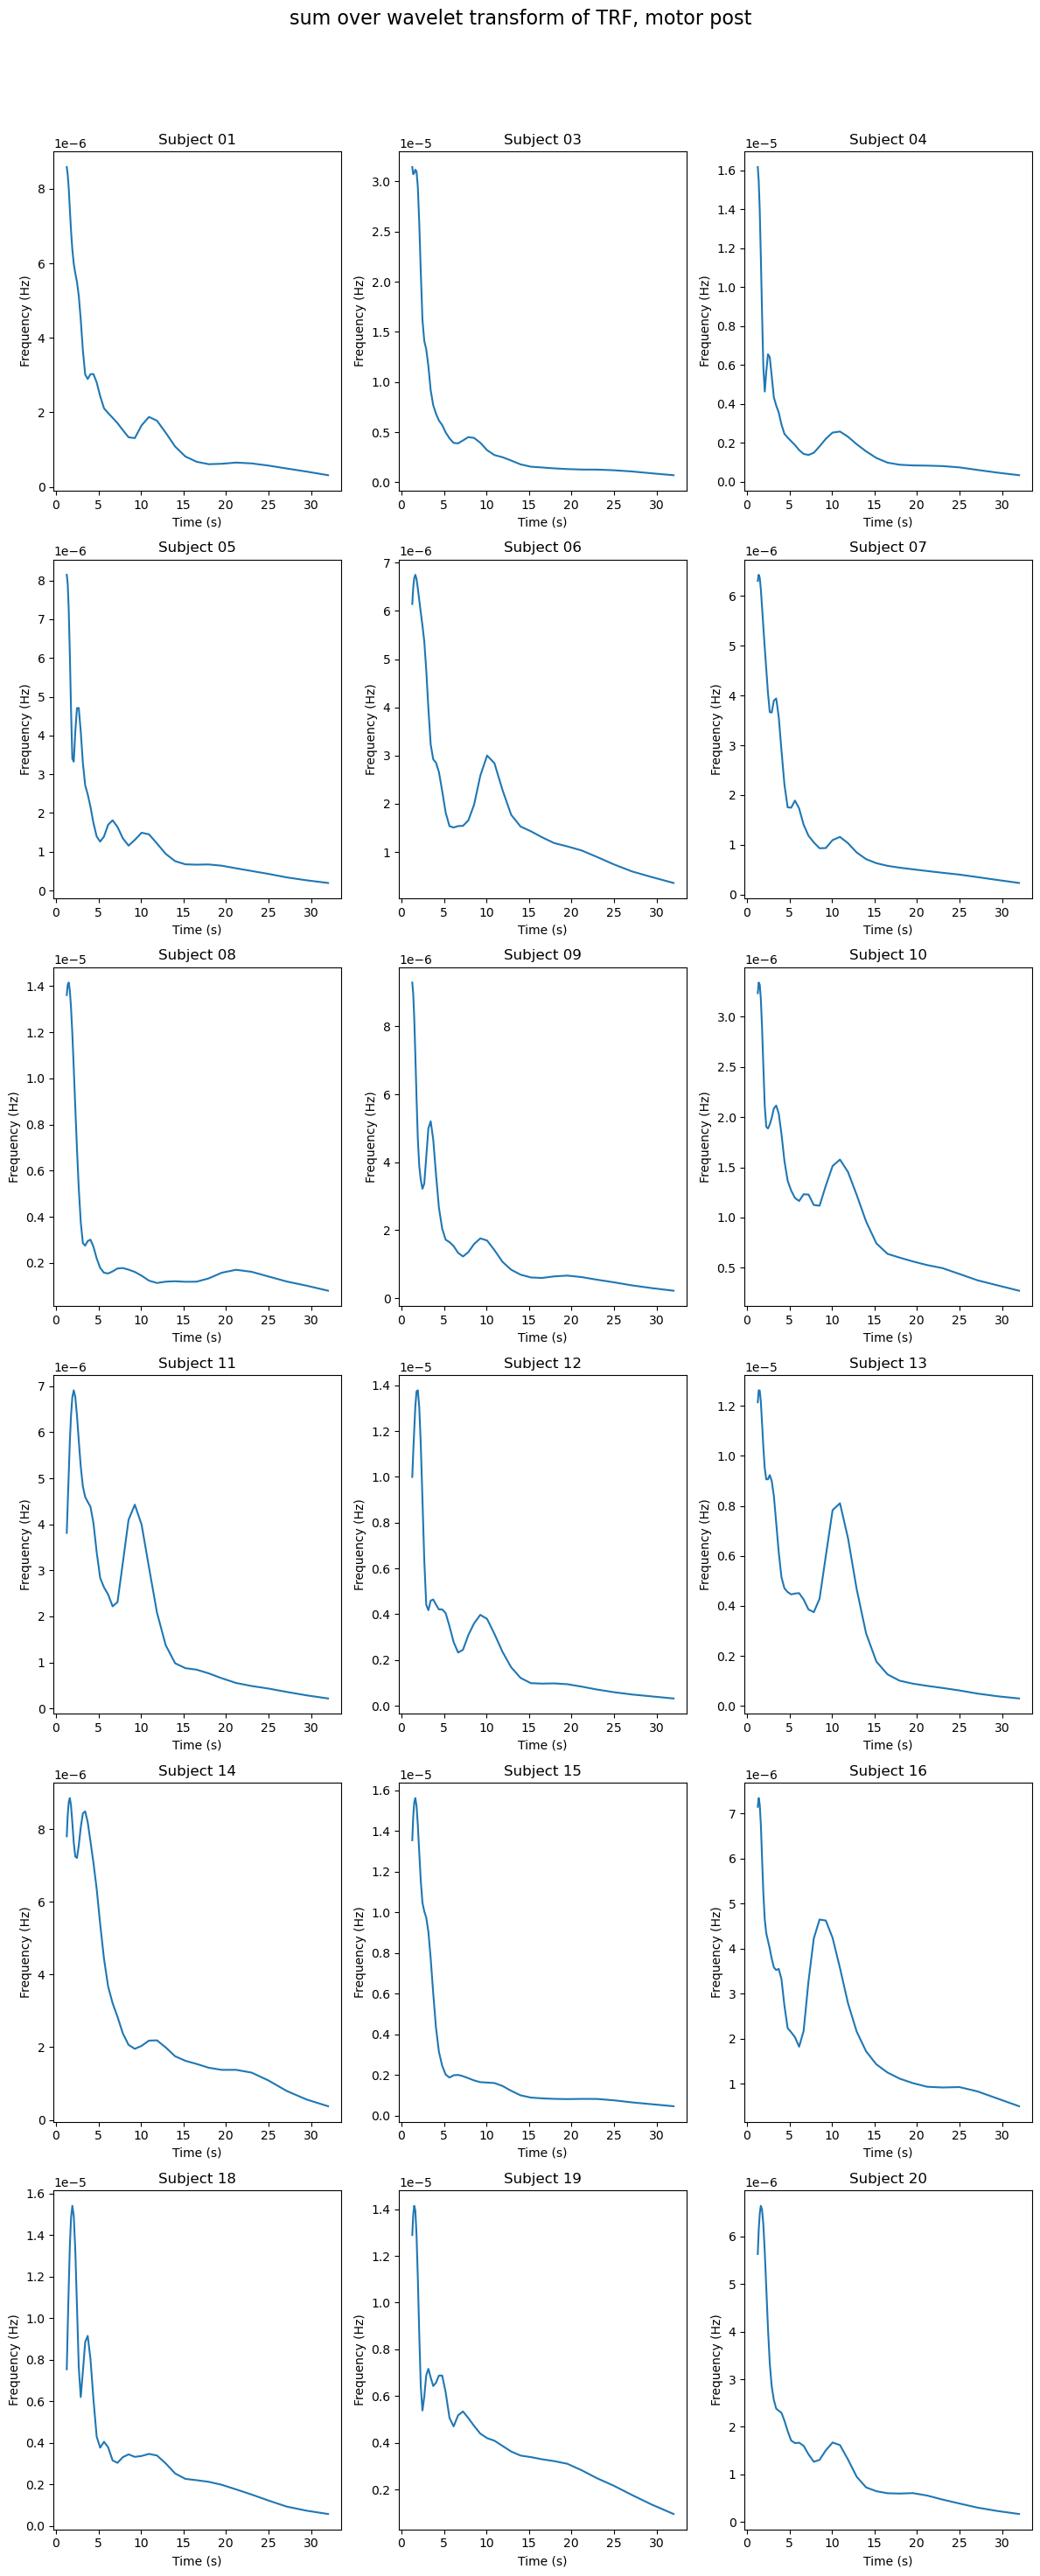

In [ ]:

period = 'post'
wavelet_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/mTRF_onset/wavelet_{task}_all'

# Define grid layout for subplots
num_columns = 3  # Adjust the number of columns as needed
num_rows = math.ceil(len(subjects_to_process) / num_columns)

# Create a figure
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 5 * num_rows))
axes = axes.flatten()  # Flatten to make indexing easier
fig.suptitle(f'sum over wavelet transform of TRF, {task} {period}', fontsize=16)

for i, sub in enumerate(subjects_to_process):
    # Load wavelet data
    #if all channels 
    wavelet_data_allch = loadmat(os.path.join(wavelet_path, f'mTRF_wavelet_{task}_{period}_{sub}.mat'))['wavelet_transform'][0]
    
    #if one channel only
    #wavelet_data = loadmat(os.path.join(wavelet_path, f'mTRF_wavelet_{task}_{period}_{sub}.mat'))['wavelet_transform'][0][0]

    wavelet_data = np.mean(wavelet_data_allch, axis = 0)
    wavelet_trans_info = loadmat(os.path.join(wavelet_path, 'wavelet_record.mat'))

    times = wavelet_trans_info['times'].squeeze() 
    freqs = wavelet_trans_info['freqs'].squeeze()

    wavelet_trans_sum = np.sum(wavelet_data, axis = 1)

    # Plot on the respective subplot
    ax = axes[i]
    ax.plot(freqs, wavelet_trans_sum)
    ax.set_title(f'Subject {sub}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    #ax.set_ylim(8,32)

# Turn off unused subplots
for j in range(len(subjects_to_process), len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [231]:
def wavelet_sums_subjects(subjects_to_process, wavelet_path, period, task):
    summed_df = pd.DataFrame(columns=['subject', 'summed_wavelet'])
    
    for sub in subjects_to_process:
        # Load wavelet data
        wavelet_data_allch = loadmat(os.path.join(wavelet_path, f'mTRF_wavelet_{task}_{period}_{sub}.mat'))['wavelet_transform'][0]
        wavelet_data_mean = np.mean(wavelet_data_allch, axis=0).squeeze()
        wavelet_summed = np.sum(wavelet_data_mean, axis=1)
 
        
        # Append data to the dataframe
        summed_df = summed_df.append({'subject': sub, 'summed_wavelet': wavelet_summed}, ignore_index=True)
    
    return summed_df


In [232]:

summed_pre = wavelet_sums_subjects(subjects_to_process, wavelet_path, 'pre',  task)
summed_post = wavelet_sums_subjects(subjects_to_process, wavelet_path, 'post', task)

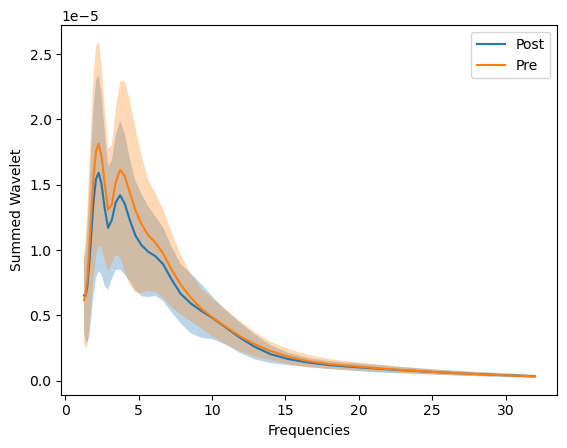

In [233]:
import numpy as np

# Stack the arrays into a 2D array (subjects x frequencies)
summed_post_array = np.stack(summed_post['summed_wavelet'].values)
summed_pre_array = np.stack(summed_pre['summed_wavelet'].values)

# Compute mean and std across subjects (row-wise)
mean_post = np.mean(summed_post_array, axis=0)
std_post = np.std(summed_post_array, axis=0)

mean_pre = np.mean(summed_pre_array, axis=0)
std_pre = np.std(summed_pre_array, axis=0)

# Plot with shaded standard deviation
plt.plot(freqs, mean_post, label='Post')
plt.fill_between(freqs, mean_post - std_post, mean_post + std_post, alpha=0.3)

plt.plot(freqs, mean_pre, label='Pre')
plt.fill_between(freqs, mean_pre - std_pre, mean_pre + std_pre, alpha=0.3)

plt.xlabel('Frequencies')
plt.ylabel('Summed Wavelet')
plt.legend()
plt.show()


In [234]:
summed_prepost = summed_pre.merge(summed_post, on='subject', suffixes=['_pre', '_post'])

In [235]:
summed_prepost['diff'] = summed_prepost['summed_wavelet_post']-summed_prepost['summed_wavelet_pre']

In [236]:
summed_prepost

,subject,summed_wavelet_pre,summed_wavelet_post,diff
0,01,"[1.9086958971462024e-07, 2.391224167806584e-07...","[2.2201515725390623e-07, 3.031173164304778e-07...","[3.1145567539285996e-08, 6.39948996498194e-08,..."
1,03,"[3.14215797086634e-07, 4.5295213981993887e-07,...","[3.9467704303751324e-07, 5.17352571843656e-07,...","[8.046124595087922e-08, 6.440043202371708e-08,..."
2,04,"[3.8138350063924595e-07, 5.694111720495723e-07...","[3.4171524110424224e-07, 5.05078270762376e-07,...","[-3.966825953500371e-08, -6.433290128719624e-0..."
3,05,"[4.17873635628882e-07, 5.179763942146951e-07, ...","[2.6767927086414605e-07, 3.7455953767155843e-0...","[-1.5019436476473597e-07, -1.4341685654313666e..."
4,06,"[4.314907847624195e-07, 5.670412595578107e-07,...","[4.701089176106498e-07, 6.208693327763154e-07,...","[3.861813284823029e-08, 5.3828073218504746e-08..."
5,07,"[2.3738521884656496e-07, 3.444827969720382e-07...","[2.4644068006047e-07, 3.3062615012281305e-07, ...","[9.055461213905044e-09, -1.3856646849225124e-0..."
6,08,"[4.4010714908997874e-07, 5.624164273347948e-07...","[7.510024677550451e-07, 9.245640896246843e-07,...","[3.1089531866506636e-07, 3.621476622898895e-07..."
7,09,"[3.087628927819493e-07, 3.8783655160400537e-07...","[2.0456306203516885e-07, 2.5207020211016955e-0...","[-1.0419983074678044e-07, -1.3576634949383582e..."
8,10,"[2.2535155382438692e-07, 3.1076754498084336e-0...","[2.1929596885509527e-07, 2.637865976485128e-07...","[-6.055584969291656e-09, -4.698094733233058e-0..."
9,11,"[2.144580264331026e-07, 3.097382464522939e-07,...","[2.1079364976679367e-07, 3.006287944167568e-07...","[-3.6643766663089253e-09, -9.109452035537086e-..."


In [237]:
diffs = np.vstack(summed_prepost['diff'])

In [238]:
diffs.shape

(18, 40)

In [239]:
t, p = t_within_points(diffs)

testing gaussianity over 18 points
Distribution is not normal. p =  0.00010984843097345351
using wilcoxon test
fdr correction over all p values


In [240]:
p


array([0.95054408, 0.95618615, 0.95618615, 1.        , 0.90121101,
       0.82541189, 0.63185556, 0.61794705, 0.39393311, 0.21622976,
       0.14984131, 0.21622976, 0.83815575, 0.95618615, 0.90121101,
       0.77312215, 0.14984131, 0.14984131, 0.14984131, 0.15512567,
       0.16285706, 0.14984131, 0.14984131, 0.14984131, 0.14984131,
       0.15512567, 0.14984131, 0.14984131, 0.21582864, 0.17098563,
       0.15512567, 0.14984131, 0.14984131, 0.14984131, 0.14984131,
       0.14984131, 0.14984131, 0.46737671, 0.95618615, 0.72084624])